# 2025-10-16 第一次测试Qwen3 embedding 4B 的部署
## 输入：BCI IV2a 中对应标签的prompt
## 输出：对应的句向量
### 该文档最后完成了左右手的区分，宣告第一阶段closed

In [1]:
# 安装所需库（第一次用到再运行；已安装可跳过）
# !pip install -U sentence-transformers transformers accelerate scikit-learn matplotlib
# 可选：显存紧张时装 8-bit 推理（降低显存占用）
# !pip install bitsandbytes

In [1]:
# 1) 基本 GPU 信息
import torch, os, subprocess, sys
print("Torch:", torch.__version__, "| CUDA 可用:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    free, total = torch.cuda.mem_get_info()
    print(f"显存: 可用 {free/1024**3:.2f} GB / 总计 {total/1024**3:.2f} GB")

Torch: 2.8.0+cu128 | CUDA 可用: True
GPU: NVIDIA A100 80GB PCIe
显存: 可用 78.84 GB / 总计 79.25 GB


## 1.加载模型与基础配置

In [2]:
# 导入常用库
import os
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random

# 固定随机种子，保证 t-SNE 可视化尽量可复现
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# 选择设备（有 GPU 就用 GPU）
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

## 2.准备 BCI IV-2a 的四类英文描述（带指令）

In [3]:
# 统一的英文指令（建议保留）
INSTRUCT = (
    "The subject is seated comfortably in an armchair facing a computer screen, performing motor imagery tasks. "
    "Produce an embedding for retrieval with a strong emphasis on LATERALITY: "
    "if the text mentions the LEFT hand, assume exclusively left-hand imagery with NO right-hand involvement; "
    "if the text mentions the RIGHT hand, assume exclusively right-hand imagery with NO left-hand involvement. "
    "Do not include any movement for the non-mentioned hand."
)


TEMPLATES = [
"imagined movement of the {label}",
"motor imagery of the {label}",
"imagine moving the {label}",
"MI task: {label} movement",
"{label} motor imagery",
]

# 标签映射（写成自然短语）
label_text = {
    "left_hand":  "left hand",
    "right_hand": "right hand",
    "feet":       "both feet",
    "tongue":     "tongue",
}

prompts = {}
for k, v in label_text.items():
    prompts[k] = [tpl.format(label=v) for tpl in TEMPLATES]


## 3.加载 Qwen3-Embedding-4B 并批量编码

In [4]:
# 加载 Qwen3-Embedding-4B（也可改成 0.6B/8B：Qwen/Qwen3-Embedding-0.6B 或 -8B）
model_name = "Qwen/Qwen3-Embedding-0.6B"

# 说明：
# - SentenceTransformer 会自动处理 tokenizer + pooling，并支持 normalize_embeddings=True
# - 需较新版本的 transformers>=4.51.0、sentence-transformers>=2.7.0
model = SentenceTransformer(model_name, device=DEVICE)

# 将 prompts 展平为列表，并保留类别标签，便于可视化着色
all_texts = []   # 存放完整的“指令+句子”字符串
all_labels = []  # 存放类别名（left_hand/right_hand/...）

for cls, sents in prompts.items():
    # 给每条句子前面加统一指令
    ins_inputs = [INSTRUCT + s for s in sents]
    all_texts.extend(ins_inputs)
    all_labels.extend([cls]*len(sents))

len(all_texts), all_labels[:3]


(20, ['left_hand', 'left_hand', 'left_hand'])

## 4.生成句向量、L2 归一化并保存

In [5]:
# 批量编码，开启 normalize_embeddings=True 直接得到单位向量（L2=1）
embeddings = model.encode(
    all_texts,
    batch_size=32,                 # 可按显存调大/调小
    normalize_embeddings=True,     # 输出向量会做 L2 归一化
    convert_to_numpy=True,         # 直接拿到 numpy 数组
    show_progress_bar=True,
)

print("句向量形状:", embeddings.shape)  # 形如 (N, D)，N=所有句子条数，D=向量维度

# 保存向量与标签，便于后续复现实验或做零样本原型
os.makedirs("text_embeddings", exist_ok=True)
np.save("text_embeddings/embeddings.npy", embeddings)
np.save("text_embeddings/labels.npy", np.array(all_labels))
print("已保存到 text_embeddings/embeddings.npy 与 labels.npy")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

句向量形状: (20, 1024)
已保存到 text_embeddings/embeddings.npy 与 labels.npy


## 5.t-SNE 降维并可视化（二维散点）

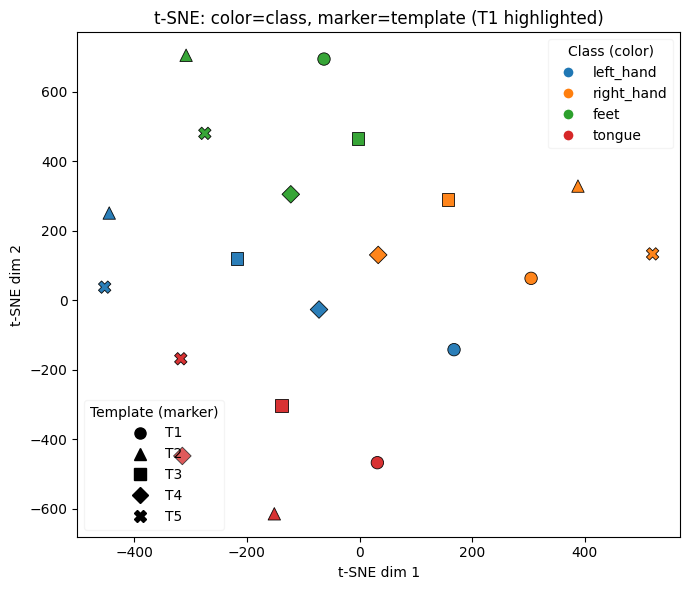

In [6]:
# —— 把每条文本映射到模板编号（T1~T5）——
def get_template_id(text, instruct=INSTRUCT):
    s = text.strip()
    if s.startswith(instruct):
        s = s[len(instruct):].strip()
    s0 = s.lower()
    if s0.startswith("imagined movement of"):   # T1
        return "T1"
    if s0.startswith("motor imagery of"):       # T2
        return "T2"
    if s0.startswith("imagine moving the"):     # T3
        return "T3"
    if s0.startswith("mi task"):               # T4
        return "T4"
    if " motor imagery" in s0:                  #T5
        return "T5"
    return "OTHER"

template_ids = [get_template_id(t) for t in all_texts]

# —— 颜色=类别（你已有），形状=模板 —— 
cls2color = {"left_hand":"#1f77b4","right_hand":"#ff7f0e","feet":"#2ca02c","tongue":"#d62728"}
marker_map = {"T1":"o","T2":"^","T3":"s","T4":"D","T5":"X","OTHER":"P"}  # 圆/三角/方/菱/叉/五边

colors = [cls2color[c] for c in all_labels]

# —— t-SNE（保持你的参数不变）——
tsne = TSNE(n_components=2, perplexity=15, learning_rate=200, max_iter=1500,
            random_state=SEED, init="pca")
emb_2d = tsne.fit_transform(embeddings)

# —— 绘图：按模板分组画（形状区分）；T1 额外黑描边高亮 —— 
plt.figure(figsize=(7, 6))
uniq_temps = sorted(set(template_ids), key=lambda x: ("T" not in x, x))  # T1..T5 排前

for tid in uniq_temps:
    idx = [i for i, t in enumerate(template_ids) if t == tid]
    plt.scatter(emb_2d[idx,0], emb_2d[idx,1],
                c=[colors[i] for i in idx], marker=marker_map[tid],
                s=80, alpha=0.95, edgecolors="black", linewidths=0.6, label=tid)

# —— 两个图例：颜色=类别；形状=模板 —— 
legend_color = [Line2D([0],[0], marker='o', color='w', label=k,
                       markerfacecolor=v, markersize=8) for k,v in cls2color.items()]
leg1 = plt.legend(handles=legend_color, title="Class (color)", loc="upper right", frameon=True,framealpha=0.2)

legend_marker = [Line2D([0],[0], marker=marker_map[t], color='k', linestyle='None',
                        label=t, markersize=8) for t in uniq_temps]
leg2 = plt.legend(handles=legend_marker, title="Template (marker)", loc="lower left", frameon=True,framealpha=0.2)
plt.gca().add_artist(leg1)

plt.title("t-SNE: color=class, marker=template (T1 highlighted)")
plt.xlabel("t-SNE dim 1"); plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


## 6.左右手的余弦相似距离

In [7]:
import numpy as np
import pandas as pd

labels_order = ["left_hand", "right_hand", "feet", "tongue"]

print("\n=== Pairwise cosine distance per template (class prototypes) ===")
for tid in sorted(set(template_ids), key=lambda x: ("T" not in x, x)):  # T1..T5 排前
    # 收集该模板下每个类别的向量索引
    cls2idx = {
        cls: [i for i, (t, c) in enumerate(zip(template_ids, all_labels)) if t == tid and c == cls]
        for cls in labels_order
    }
    # 统计缺失类别
    missing = [cls for cls, idxs in cls2idx.items() if len(idxs) == 0]
    if missing:
        print(f"\n[Template {tid}] 缺少类别: {missing}（将基于可用类别计算）")

    # 计算每个“有数据”的类别原型：类内均值后再 L2 归一化
    used_labels = [cls for cls in labels_order if len(cls2idx[cls]) > 0]
    if len(used_labels) < 2:
        print(f"[Template {tid}] 可用类别不足以计算两两距离（仅 {used_labels}）。")
        continue

    protos = []
    for cls in used_labels:
        vecs = embeddings[cls2idx[cls]]                      # 该模板下该类的所有句向量
        mean_vec = vecs.mean(axis=0)                          # 类内均值
        mean_vec = mean_vec / (np.linalg.norm(mean_vec) + 1e-12)  # 再做一次 L2，确保单位向量
        protos.append(mean_vec)
    protos = np.stack(protos, axis=0)                         # [K, D]

    # 余弦相似度/距离矩阵
    sim = protos @ protos.T                                   # [K, K]（已单位化，点积即余弦）
    dist = 1.0 - sim                                          # 余弦距离

    # 打印为表格
    df = pd.DataFrame(dist, index=used_labels, columns=used_labels)
    print(f"\n[Template {tid}] cosine distance matrix (0=相同, 越大越远):")
    print(df.round(3))

    # 也可顺便打印 left↔right 的距离（如果都在）
    if "left_hand" in used_labels and "right_hand" in used_labels:
        li = used_labels.index("left_hand"); ri = used_labels.index("right_hand")
        print(f" -> left vs right 距离: {dist[li, ri]:.3f}")



=== Pairwise cosine distance per template (class prototypes) ===

[Template T1] cosine distance matrix (0=相同, 越大越远):
            left_hand  right_hand   feet  tongue
left_hand       0.000       0.047  0.070   0.088
right_hand      0.047       0.000  0.086   0.103
feet            0.070       0.086  0.000   0.111
tongue          0.088       0.103  0.111  -0.000
 -> left vs right 距离: 0.047

[Template T2] cosine distance matrix (0=相同, 越大越远):
            left_hand  right_hand   feet  tongue
left_hand       0.000       0.053  0.102   0.128
right_hand      0.053       0.000  0.113   0.139
feet            0.102       0.113 -0.000   0.158
tongue          0.128       0.139  0.158  -0.000
 -> left vs right 距离: 0.053

[Template T3] cosine distance matrix (0=相同, 越大越远):
            left_hand  right_hand   feet  tongue
left_hand       0.000       0.012  0.017   0.042
right_hand      0.012       0.000  0.022   0.049
feet            0.017       0.022  0.000   0.047
tongue          0.042       0.049  0

## 7.计算类别“单原型”（均值向量），保存以备零样本分类

In [8]:
# 以“类内均值 + 再 L2”作为单原型，用于后续零样本/相似度匹配
def l2norm(x, axis=-1, eps=1e-12):
    norm = np.linalg.norm(x, axis=axis, keepdims=True) + eps
    return x / norm

classes = ["left_hand", "right_hand", "feet", "tongue"]
protos = []
for c in classes:
    idx = [i for i, lab in enumerate(all_labels) if lab == c]
    mean_vec = embeddings[idx].mean(axis=0)
    mean_vec = l2norm(mean_vec[None, :], axis=1)[0]  # 均值后再 L2
    protos.append(mean_vec)

W_text_single = np.stack(protos, axis=0)  # 形状 (4, D)
np.save("text_embeddings/W_text_single.npy", W_text_single)
print("已保存类原型: text_embeddings/W_text_single.npy  (shape:", W_text_single.shape, ")")


已保存类原型: text_embeddings/W_text_single.npy  (shape: (4, 1024) )
